In [ ]:
import json
import math
import os
import requests
import scipy
import tifffile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from datetime import datetime as dt
from scipy import stats as st
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
from keras import metrics

from google.colab import drive
from google.colab import files
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Read Tiles Dataset**

In [ ]:
tiles = pd.read_csv(r'/content/drive/MyDrive/capstone/Tiles.csv')

In [ ]:
tiles.head(5)

,Unnamed: 0,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long
0,0,0,37.708251,37.709155,-122.391313,-122.392454,37.708703,-122.391884
1,1,1,37.708251,37.709155,-122.392454,-122.393594,37.708703,-122.393024
2,2,2,37.708251,37.709155,-122.393594,-122.394734,37.708703,-122.394164
3,3,3,37.708251,37.709155,-122.394734,-122.395874,37.708703,-122.395304
4,4,4,37.708251,37.709155,-122.395874,-122.397014,37.708703,-122.396444


In [ ]:
len(tiles)

12227

**Split street characterstics into tiles**

Stop signs <br>
https://data.sfgov.org/Transportation/Stop-Signs/4542-gpa3

In [ ]:
stops = pd.read_csv(r'/content/drive/MyDrive/capstone/Stop_Signs.csv')
#stops.head(5)

In [ ]:
stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10639 entries, 0 to 10638
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   STREET                        10639 non-null  object 
 1   X_STREET                      10639 non-null  object 
 2   DIRECTION                     9895 non-null   object 
 3   ST_FACING                     10639 non-null  object 
 4   DIST                          7028 non-null   object 
 5   CNN                           10624 non-null  float64
 6   CONCATENAT                    10420 non-null  object 
 7   MTAB_DATE                     576 non-null    float64
 8   MTAB_RESO_TEXT                2 non-null      object 
 9   MTAB_MOTION                   586 non-null    object 
 10  STATUS                        1615 non-null   object 
 11  WORKORDER                     438 non-null    object 
 12  INSTALL_DATE                  334 non-null    float64
 13  s

In [ ]:
# all stop signs have lat/long 
pd.notnull(stops['shape']).unique()

array([ True])

In [ ]:
import re

stop_lat = []
stop_long = []
for i in stops['shape']: 
    split = re.split(' |\(|\)', i)
    stop_lat = np.append(stop_lat, float(split[3]))
    stop_long = np.append(stop_long, float(split[2]))
    
stops['latitude'] = stop_lat
stops['longitude'] = stop_long

In [ ]:
stops.head(5)

,STREET,X_STREET,DIRECTION,ST_FACING,DIST,CNN,CONCATENAT,MTAB_DATE,MTAB_RESO_TEXT,MTAB_MOTION,...,WORKORDER,INSTALL_DATE,shape,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,latitude,longitude
0,MORAGA ST,45TH AVE,NE,WB,0,27930000.0,MORAGA ST & 45TH AVE,2.021062e+13,NaN,6423,...,21-02595,2.021072e+13,POINT (-122.50446 37.75488),39.0,39.0,10,7,35,37.754880,-122.504460
1,PERU,ATHENS,NaN,EB,NaN,21652000.0,NaN,NaN,NaN,NaN,...,NaN,NaN,POINT (-122.42493 37.726322),90.0,90.0,9,1,7,37.726322,-122.424930
2,LA PLAYA ST,JUDAH,NW,SB,0,27960000.0,LA PLAYA ST & JUDAH,NaN,NaN,NaN,...,NaN,NaN,POINT (-122.50914 37.76028),39.0,39.0,10,7,35,37.760280,-122.509140
3,37TH AVE,CABRILLO,NW,SB,0,27863000.0,37TH AVE & CABRILLO,NaN,NaN,NaN,...,NaN,NaN,POINT (-122.497185 37.77385),8.0,8.0,8,4,29,37.773850,-122.497185
4,PRESIDIO,GEARY,SE,NB,NaN,26834000.0,PRESIDIO AVE & GEARY BLVD,NaN,NaN,NaN,...,NaN,NaN,POINT (-122.44582 37.78249),13.0,13.0,8,6,18,37.782490,-122.445820


In [ ]:
stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10639 entries, 0 to 10638
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   STREET                        10639 non-null  object 
 1   X_STREET                      10639 non-null  object 
 2   DIRECTION                     9895 non-null   object 
 3   ST_FACING                     10639 non-null  object 
 4   DIST                          7028 non-null   object 
 5   CNN                           10624 non-null  float64
 6   CONCATENAT                    10420 non-null  object 
 7   MTAB_DATE                     576 non-null    float64
 8   MTAB_RESO_TEXT                2 non-null      object 
 9   MTAB_MOTION                   586 non-null    object 
 10  STATUS                        1615 non-null   object 
 11  WORKORDER                     438 non-null    object 
 12  INSTALL_DATE                  334 non-null    float64
 13  s

In [ ]:
stop = []
for i in range(len(tiles)):
    ti = tiles.iloc[i]
    lat1 = ti['Lat1']
    lat2 = ti['Lat2']
    long1 = ti['Long1']
    long2 = ti['Long2']
    f = len(stops[(stops['latitude'] < lat2) & (stops['latitude'] > lat1) & (stops['longitude'] > long2) & (stops['longitude'] < long1)])
    stop = np.append(stop,f)

In [ ]:
tiles['Stop_Signs'] = stop

In [ ]:
tiles[tiles['Stop_Signs'] > 0]

,Unnamed: 0,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long,Stop_Signs
1,1,1,37.708251,37.709155,-122.392454,-122.393594,37.708703,-122.393024,3.0
2,2,2,37.708251,37.709155,-122.393594,-122.394734,37.708703,-122.394164,1.0
12,12,12,37.708251,37.709155,-122.404995,-122.406135,37.708703,-122.405565,1.0
20,20,20,37.708251,37.709155,-122.414116,-122.415256,37.708703,-122.414686,3.0
21,21,21,37.708251,37.709155,-122.415256,-122.416396,37.708703,-122.415826,4.0
...,...,...,...,...,...,...,...,...,...
11995,11995,11995,37.805840,37.806744,-122.423237,-122.424377,37.806292,-122.423807,3.0
12005,12005,12005,37.805840,37.806744,-122.434638,-122.435778,37.806292,-122.435208,3.0
12009,12009,12009,37.805840,37.806744,-122.439198,-122.440338,37.806292,-122.439768,4.0
12055,12055,12055,37.806744,37.807648,-122.418676,-122.419816,37.807196,-122.419246,5.0


Bus Stops

In [ ]:
bus_stops = pd.read_csv(r'/content/drive/MyDrive/capstone/Muni_Stops.csv')
#bus_stops.head(5)

In [ ]:
bus_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3249 entries, 0 to 3248
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OBJECTID                      3249 non-null   int64  
 1   STOPNAME                      3249 non-null   object 
 2   TRAPEZESTOPABBR               3249 non-null   object 
 3   RUCUSSTOPABBR                 2874 non-null   object 
 4   STOPID                        3249 non-null   int64  
 5   LATITUDE                      3249 non-null   float64
 6   LONGITUDE                     3249 non-null   float64
 7   ACCESSIBILITYMASK             3063 non-null   float64
 8   ATSTREET                      3162 non-null   object 
 9   ONSTREET                      3243 non-null   object 
 10  POSITION                      2862 non-null   object 
 11  ORIENTATION                   2884 non-null   object 
 12  SERVICEPLANNINGSTOPTYPE       1573 non-null   object 
 13  SHE

In [ ]:
bus_stop = []
for i in range(len(tiles)):
    ti = tiles.iloc[i]
    lat1 = ti['Lat1']
    lat2 = ti['Lat2']
    long1 = ti['Long1']
    long2 = ti['Long2']
    f = len(bus_stops[(bus_stops['LATITUDE'] < lat2) & (bus_stops['LATITUDE'] > lat1) & (bus_stops['LONGITUDE'] > long2) & (bus_stops['LONGITUDE'] < long1)])
    bus_stop = np.append(bus_stop,f)

In [ ]:
tiles['Bus_stop'] = bus_stop

In [ ]:
tiles[tiles['Bus_stop'] > 0]

,Unnamed: 0,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long,Stop_Signs,Bus_stop
2,2,2,37.708251,37.709155,-122.393594,-122.394734,37.708703,-122.394164,1.0,1.0
12,12,12,37.708251,37.709155,-122.404995,-122.406135,37.708703,-122.405565,1.0,5.0
18,18,18,37.708251,37.709155,-122.411836,-122.412976,37.708703,-122.412406,0.0,2.0
25,25,25,37.708251,37.709155,-122.419816,-122.420956,37.708703,-122.420386,1.0,4.0
27,27,27,37.708251,37.709155,-122.422097,-122.423237,37.708703,-122.422667,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
12104,12104,12104,37.807648,37.808551,-122.409555,-122.410695,37.808099,-122.410125,0.0,1.0
12105,12105,12105,37.807648,37.808551,-122.410695,-122.411836,37.808099,-122.411266,0.0,1.0
12106,12106,12106,37.807648,37.808551,-122.411836,-122.412976,37.808099,-122.412406,0.0,1.0
12109,12109,12109,37.807648,37.808551,-122.415256,-122.416396,37.808099,-122.415826,0.0,1.0


Street Paving <br>
https://data.sfgov.org/d/5wbp-dwzt/about

In [ ]:
paving_all = pd.read_csv(r'/content/drive/MyDrive/capstone/Utility_Excavation_Moratorium_Streets.csv')
#paving_all.head(5)

In [ ]:
#paving = paving_all[paving_all['EffectiveDate'] < '09/30/2020']

In [ ]:
#paving.head(5)

In [ ]:
#paving = paving_all[paving_all['EffectiveDate'] < '09/30/2022']
paving = paving_all

pave = []
for i in range(len(tiles)):
    ti = tiles.iloc[i]
    lat1 = ti['Lat1']
    lat2 = ti['Lat2']
    long1 = ti['Long1']
    long2 = ti['Long2']
    f = len(paving[(paving['Latitude'] < lat2) & (paving['Latitude'] > lat1) & (paving['Longitude'] > long2) & (paving['Longitude'] < long1)])
    pave = np.append(pave,f)

Split pavement data into historical and future date groups

In [ ]:
#Split pavement data between date groups A: 10/1/2018 - 9/30/2020 and B: 10/1/2020 - 9/30/2022

def date_group(x):
    x = dt.strptime(x, "%m/%d/%Y %H:%M:%S %p")
    if (x >= dt.strptime("10/1/2018", "%m/%d/%Y")) & (x <= dt.strptime("9/30/2020", "%m/%d/%Y")):
        return "H"
    if (x >= dt.strptime("10/1/2020", "%m/%d/%Y")) & (x <= dt.strptime("9/30/2022", "%m/%d/%Y")):
        return "F"

paving['Paving_date_group'] = paving['EffectiveDate'].apply(date_group)

In [ ]:
#pavement data date groups A: 10/1/2018 - 9/30/2020
paving[paving['Paving_date_group']=='H'].head()

,CNN,Streetname,Limits,JobOrderNum,EffectiveDate,ExpirationDate,ModifiedDate,ID,X,Y,Latitude,Longitude,Location,point,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,Paving_date_group
37,28018000,CALIFORNIA ST,29TH AVE intersection,2792J,04/13/2020 12:00:00 AM,04/13/2025 12:00:00 AM,04/22/2020 02:31:50 PM,8390,5.986830e+06,2.113930e+06,37.783689,-122.489290,"(37.78368859874989, -122.48928978213416)",NaN,NaN,NaN,NaN,NaN,NaN,H
53,26972000,CHESTNUT ST,SCOTT ST intersection,2498J,01/01/2019 12:00:00 AM,01/01/2024 12:00:00 AM,05/13/2019 12:45:05 PM,9383,6.000855e+06,2.119646e+06,37.800190,-122.441177,"(37.80019017258282, -122.44117737587483)",NaN,NaN,NaN,NaN,NaN,NaN,H
56,28180000,UNION ST,SONOMA ST intersection,2794J,03/06/2019 12:00:00 AM,03/06/2024 12:00:00 AM,03/06/2019 12:52:45 PM,32689,6.010903e+06,2.119656e+06,37.800786,-122.406408,"(37.80078640332124, -122.40640795436289)",NaN,NaN,NaN,NaN,NaN,NaN,H
67,13302000,VIENNA ST,PERSIA AVE to RUSSIA AVE (500 - 599),2633J,07/01/2019 12:00:00 AM,07/01/2024 12:00:00 AM,10/24/2019 08:47:31 AM,33783,6.003191e+06,2.090282e+06,37.719697,-122.430998,"(37.71969693919677, -122.43099848723189)",NaN,NaN,NaN,NaN,NaN,NaN,H
85,3603000,CALIFORNIA ST,26TH AVE to 27TH AVE (6400 - 6499),2792J,05/22/2020 12:00:00 AM,05/22/2025 12:00:00 AM,05/22/2020 01:59:03 PM,8385,5.987602e+06,2.113958e+06,37.783809,-122.486620,"(37.783809441173005, -122.48661971093952)",NaN,NaN,NaN,NaN,NaN,NaN,H


In [ ]:
#pavement data between date groups B: 10/1/2020 - 9/30/2022
paving[paving['Paving_date_group']=='F'].head()

,CNN,Streetname,Limits,JobOrderNum,EffectiveDate,ExpirationDate,ModifiedDate,ID,X,Y,Latitude,Longitude,Location,point,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,Paving_date_group
0,13730000,WOOLSEY ST,BOWDOIN ST to DARTMOUTH ST (800 - 899),2977J,04/01/2022 12:00:00 AM,04/01/2027 12:00:00 AM,04/11/2022 09:57:48 AM,34852,6.009288e+06,2.091470e+06,37.723302,-122.410007,"(37.72330157541044, -122.41000739523302)",NaN,NaN,NaN,NaN,NaN,NaN,F
1,13731000,WOOLSEY ST,DARTMOUTH ST to COLBY ST (900 - 999),2977J,03/31/2022 12:00:00 AM,03/31/2027 12:00:00 AM,04/11/2022 09:54:08 AM,34854,6.009001e+06,2.091382e+06,37.723044,-122.410993,"(37.72304412011837, -122.41099254630903)",NaN,NaN,NaN,NaN,NaN,NaN,F
2,13732000,WOOLSEY ST,COLBY ST to UNIVERSITY ST (1000 - 1099),2977J,03/31/2022 12:00:00 AM,03/31/2027 12:00:00 AM,04/11/2022 09:54:08 AM,34856,6.008715e+06,2.091294e+06,37.722787,-122.411977,"(37.72278693382726, -122.41197662933816)",NaN,NaN,NaN,NaN,NaN,NaN,F
3,20876000,WOOLSEY ST,COLBY ST intersection,2977J,03/31/2022 12:00:00 AM,03/31/2027 12:00:00 AM,04/11/2022 09:54:08 AM,34855,6.008858e+06,2.091338e+06,37.722915,-122.411485,"(37.72291542361495, -122.41148498754468)",NaN,NaN,NaN,NaN,NaN,NaN,F
4,20868000,WOOLSEY ST,BOWDOIN ST intersection,2977J,04/01/2022 12:00:00 AM,04/01/2027 12:00:00 AM,04/11/2022 09:57:48 AM,34851,6.009431e+06,2.091514e+06,37.723430,-122.409515,"(37.72343033432908, -122.4095146857055)",NaN,NaN,NaN,NaN,NaN,NaN,F


In [ ]:
tiles['Paving'] = pave

In [ ]:
tiles[tiles['Paving'] > 0]

,Unnamed: 0,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long,Stop_Signs,Bus_stop,Paving
12,12,12,37.708251,37.709155,-122.404995,-122.406135,37.708703,-122.405565,1.0,5.0,4.0
14,14,14,37.708251,37.709155,-122.407275,-122.408415,37.708703,-122.407845,0.0,0.0,1.0
19,19,19,37.708251,37.709155,-122.412976,-122.414116,37.708703,-122.413546,0.0,0.0,1.0
21,21,21,37.708251,37.709155,-122.415256,-122.416396,37.708703,-122.415826,4.0,0.0,1.0
22,22,22,37.708251,37.709155,-122.416396,-122.417536,37.708703,-122.416966,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
12107,12107,12107,37.807648,37.808551,-122.412976,-122.414116,37.808099,-122.413546,0.0,0.0,1.0
12108,12108,12108,37.807648,37.808551,-122.414116,-122.415256,37.808099,-122.414686,0.0,0.0,3.0
12109,12109,12109,37.807648,37.808551,-122.415256,-122.416396,37.808099,-122.415826,0.0,1.0,2.0
12110,12110,12110,37.807648,37.808551,-122.416396,-122.417536,37.808099,-122.416966,0.0,0.0,2.0


311 Cases <br>
https://data.sfgov.org/City-Infrastructure/311-Cases/vw6y-z8j6

In [ ]:
#cases = pd.read_csv(r'.\Data\311_Cases.csv')
#cases.head(5)

In [ ]:
#stop = []
#for i in range(len(tiles)):
#    ti = tiles.iloc[i]
#    lat1 = ti['Lat1']
#    lat2 = ti['Lat2']
#    long1 = ti['Long1']
#    long2 = ti['Long2']
#    f = len(stop[(stop['latitude'] < lat2) & (stop['latitude'] > lat1) & (stop['longitude'] > long2) & (stop['longitude'] < long1)])
#    stop = np.append(stop,f)

In [ ]:
#tiles['Stop_Signs'] = stop

Split historical and future collision data into tiles

In [ ]:
collisions = pd.read_csv(r'/content/drive/MyDrive/capstone/transbase_collisions_02112023.csv')
collisions.head(5)

#collisions.columns

# dataset is from 2017 - September 30 2022
# Historical Group: Oct 1 2018 - September 30 2020
# Future Group: Oct 1 2020 - September 30 2022

collisions['Historical'] = np.where((collisions['collision_date'] >= 20181001) & (collisions['collision_date'] <= 20200930),1,0)

collisions['Future'] = np.where((collisions['collision_date'] >= 20201001) & (collisions['collision_date'] <= 20220930),1,0)

collisions.head(5)

,type,geometry,case_id_pkey,collision_severity,accident_year,collision_date,collision_time,distance,direction,pcf_viol_category,...,bndy_type,party_at_fault,party1_type,party1_dir_of_travel,party1_move_pre_acc,party2_type,party2_dir_of_travel,party2_move_pre_acc,Historical,Future
0,Feature,[object Object],17045414,Injury (Complaint of Pain),2017,20171227,1849.0,0,Not Stated,Unknown,...,Geographic Boundary,1.0,Driver,South,Proceeding Straight,Driver,East,Proceeding Straight,0,0
1,Feature,[object Object],170800277,Injury (Complaint of Pain),2017,20171001,145.0,28,South,Unsafe speed for prevailing conditions,...,Geographic Boundary,1.0,Driver,North,Proceeding Straight,Driver,North,Making Left Turn,0,0
2,Feature,[object Object],170800299,Injury (Other Visible),2017,20171001,233.0,0,Not Stated,Violation of right-of-way - left turn,...,Geographic Boundary,1.0,Driver,East,Making Left Turn,Driver,South,Proceeding Straight,0,0
3,Feature,[object Object],170801106,Injury (Other Visible),2017,20171001,1228.0,99,East,Violation of right-of-way - left turn,...,Geographic Boundary,1.0,Driver,West,Making U Turn,Bicyclist,West,Proceeding Straight,0,0
4,Feature,[object Object],170801225,Injury (Complaint of Pain),2017,20171001,1300.0,210,North,Opening door on traffic side when unsafe,...,Geographic Boundary,1.0,Other,South,Stopped In Road,Driver,South,Passing Other Vehicle,0,0


In [ ]:
collisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14866 entries, 0 to 14865
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   type                     14866 non-null  object 
 1   geometry                 14866 non-null  object 
 2   case_id_pkey             14866 non-null  object 
 3   collision_severity       14866 non-null  object 
 4   accident_year            14866 non-null  int64  
 5   collision_date           14866 non-null  int64  
 6   collision_time           14858 non-null  float64
 7   distance                 14866 non-null  int64  
 8   direction                14866 non-null  object 
 9   pcf_viol_category        14866 non-null  object 
 10  pcf_violation            14833 non-null  object 
 11  pcf_viol_subsection      0 non-null      float64
 12  type_of_collision        14866 non-null  object 
 13  mviw                     14866 non-null  object 
 14  street_view           

In [ ]:
collisions['collision_severity'].unique()

array(['Injury (Complaint of Pain)', 'Injury (Other Visible)',
       'Injury (Severe)', 'Fatal'], dtype=object)

In [ ]:
# adding historical and future collisions to data frame

# 'Tile_ID', 'Lat1', 'Lat2', 'Long1', 'Long2', 'Mid'
collisions_fh = collisions[(collisions['Future'] == 1) | (collisions['Historical'] == 1)]
collisions_f = collisions[collisions['Future'] == 1]
collisions_h = collisions[collisions['Historical'] == 1]
# for every tile, sum the future and historical collisions 
# the collision should take place within the tile 
fut = []
his = []
for i in range(len(tiles)):
    ti = tiles.iloc[i]
    lat1 = ti['Lat1']
    lat2 = ti['Lat2']
    long1 = ti['Long1']
    long2 = ti['Long2']
    f = len(collisions_f[(collisions_f['latitude'] < lat2) & (collisions_f['latitude'] > lat1) & (collisions_f['longitude'] > long2) & (collisions_f['longitude'] < long1)])
    h = len(collisions_h[(collisions_h['latitude'] < lat2) & (collisions_h['latitude'] > lat1) & (collisions_h['longitude'] > long2) & (collisions_h['longitude'] < long1)])
    fut = np.append(fut,f)
    his = np.append(his,h)

In [ ]:
tiles['Collisions_Future'] = fut
tiles['Collisions_Historical'] = his

In [ ]:
tiles = tiles.drop(['Unnamed: 0'], axis=1)

In [ ]:
def get_score(x):
    if (0.80 < x) & (x <= 1):
         return 1
    if (0.60 < x) & (x <= 0.80):
         return 0.8
    if (0.40 < x) & (x <= 0.60):
         return 0.6
    if (0.20 < x) & (x <= 0.40):
         return 0.4
    if (0.00 < x) & (x <= 0.20):
         return 0.2
    if x == 0.00:
         return 0

def get_class(x):
    if x > 0:
        return 1
    if x == 0:
        return 0

#tiles['Collision_rate_historical'] = tiles['Collisions_Historical']/tiles['Collisions_Historical'].max()

#tiles['Collision_rate_score_historical'] = tiles['Collision_rate'].apply(get_score)

tiles['Collision_binary_historical'] = tiles['Collisions_Historical'].apply(get_class)

#tiles['Collision_rate_future'] = tiles[Collisions_Future']/tiles[Collisions_Future'].max()

#tiles['Collision_rate_score_future'] = tiles['Collision_rate_future'].apply(get_score)

tiles['Collision_binary_future'] = tiles['Collisions_Future'].apply(get_class)

In [ ]:
#tiles['Historical'].max()
tiles.sort_values(by=['Collisions_Historical'], ascending=False)

,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long,Stop_Signs,Bus_stop,Paving,Collisions_Future,Collisions_Historical,Collision_binary_historical,Collision_binary_future
8381,8381,37.771503,37.772407,-122.423237,-122.424377,37.771955,-122.423807,1.0,0.0,0.0,19.0,21.0,1,1
8505,8505,37.772407,37.773311,-122.436918,-122.438058,37.772859,-122.437488,0.0,2.0,0.0,10.0,20.0,1,1
8491,8491,37.772407,37.773311,-122.420956,-122.422097,37.772859,-122.421527,0.0,2.0,0.0,19.0,20.0,1,1
9607,9607,37.781443,37.782347,-122.409555,-122.410695,37.781895,-122.410125,1.0,2.0,0.0,8.0,19.0,1,1
8829,8829,37.775118,37.776021,-122.415256,-122.416396,37.775570,-122.415826,1.0,0.0,0.0,11.0,18.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4380,4380,37.740781,37.741684,-122.371932,-122.373072,37.741233,-122.372502,0.0,0.0,0.0,0.0,0.0,0,0
4381,4381,37.740781,37.741684,-122.373072,-122.374212,37.741233,-122.373642,0.0,0.0,0.0,0.0,0.0,0,0
4382,4382,37.740781,37.741684,-122.374212,-122.375352,37.741233,-122.374782,0.0,0.0,0.0,0.0,0.0,0,0
4383,4383,37.740781,37.741684,-122.375352,-122.376492,37.741233,-122.375922,0.0,0.0,0.0,0.0,0.0,0,0


In [ ]:
#tiles['Future'].max()
tiles.sort_values(by=['Collisions_Future'], ascending=False)

,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long,Stop_Signs,Bus_stop,Paving,Collisions_Future,Collisions_Historical,Collision_binary_historical,Collision_binary_future
8491,8491,37.772407,37.773311,-122.420956,-122.422097,37.772859,-122.421527,0.0,2.0,0.0,19.0,20.0,1,1
8381,8381,37.771503,37.772407,-122.423237,-122.424377,37.771955,-122.423807,1.0,0.0,0.0,19.0,21.0,1,1
7578,7578,37.765178,37.766082,-122.407275,-122.408415,37.765630,-122.407845,0.0,4.0,0.0,18.0,11.0,1,1
4640,4640,37.742588,37.743492,-122.387893,-122.389033,37.743040,-122.388463,0.0,5.0,3.0,17.0,11.0,1,1
8154,8154,37.769696,37.770600,-122.419816,-122.420956,37.770148,-122.420386,1.0,0.0,0.0,17.0,17.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4341,4341,37.739877,37.740781,-122.467701,-122.468841,37.740329,-122.468271,5.0,0.0,0.0,0.0,0.0,0,0
4342,4342,37.739877,37.740781,-122.468841,-122.469981,37.740329,-122.469411,0.0,0.0,0.0,0.0,0.0,0,0
4343,4343,37.739877,37.740781,-122.469981,-122.471122,37.740329,-122.470552,0.0,0.0,1.0,0.0,0.0,0,0
4344,4344,37.739877,37.740781,-122.471122,-122.472262,37.740329,-122.471692,0.0,0.0,0.0,0.0,0.0,0,0


In [ ]:
#tiles.loc[tiles['Collisions_Historical'] == 0].head()
#tiles.loc[tiles['Collisions_Historical'] > 0].head()
#tiles.loc[tiles['COllisions_Future'] == 0].head()
#tiles.loc[tiles['Collisions_Future'] > 0].head()

In [ ]:
tiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12227 entries, 0 to 12226
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Tile_ID                      12227 non-null  int64  
 1   Lat1                         12227 non-null  float64
 2   Lat2                         12227 non-null  float64
 3   Long1                        12227 non-null  float64
 4   Long2                        12227 non-null  float64
 5   Mid_lat                      12227 non-null  float64
 6   Mid_long                     12227 non-null  float64
 7   Stop_Signs                   12227 non-null  float64
 8   Bus_stop                     12227 non-null  float64
 9   Paving                       12227 non-null  float64
 10  Collisions_Future            12227 non-null  float64
 11  Collisions_Historical        12227 non-null  float64
 12  Collision_binary_historical  12227 non-null  int64  
 13  Collision_binary

In [ ]:
columns_all = ["Tile_ID", "Lat1", "Lat2", "Long1", "Long2", "Mid_lat", "Mid_long", "Stop_Signs", "Bus_stop", "Paving", "Collisions_Future", "Collisions_Historical", "Collision_binary_historical", "Collision_binary_future"]

**Exploratory Data Analysis**

Correlation Analysis of Features for Feature Selection

In [ ]:
print(tiles.corr())

                              Tile_ID      Lat1      Lat2     Long1     Long2  \
Tile_ID                      1.000000  0.998475  0.998475 -0.045867 -0.045867   
Lat1                         0.998475  1.000000  1.000000 -0.030500 -0.030500   
Lat2                         0.998475  1.000000  1.000000 -0.030500 -0.030500   
Long1                       -0.045867 -0.030500 -0.030500  1.000000  1.000000   
Long2                       -0.045867 -0.030500 -0.030500  1.000000  1.000000   
Mid_lat                      0.998475  1.000000  1.000000 -0.030500 -0.030500   
Mid_long                    -0.045867 -0.030500 -0.030500  1.000000  1.000000   
Stop_Signs                  -0.031509 -0.035480 -0.035480 -0.011910 -0.011910   
Bus_stop                     0.031461  0.030405  0.030405  0.060503  0.060503   
Paving                       0.013564  0.012327  0.012327  0.032938  0.032938   
Collisions_Future            0.112015  0.108871  0.108871  0.132741  0.132741   
Collisions_Historical       

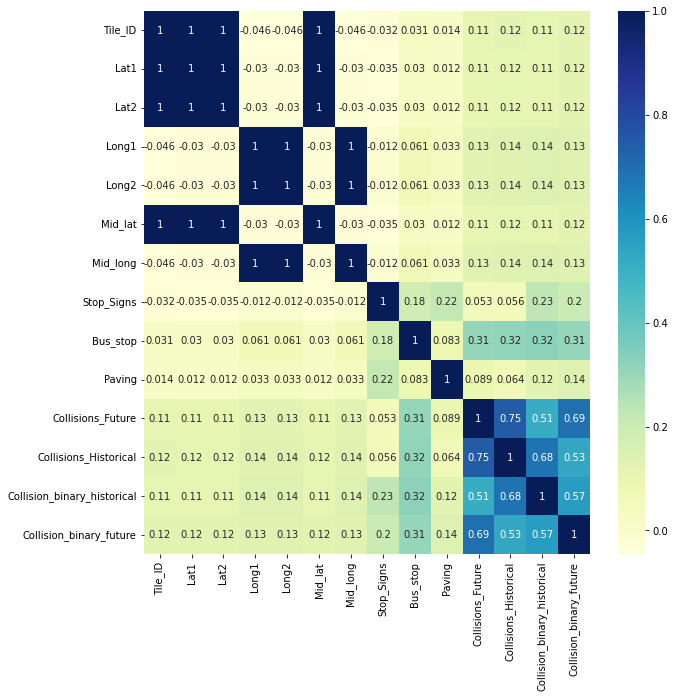

In [ ]:
# plotting correlation heatmap
fig, ax = mp.subplots(figsize=(10,10)) 
dataplot = sns.heatmap(tiles.corr(), cmap="YlGnBu", annot=True)

<ipython-input-193-8ee179e018ba>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


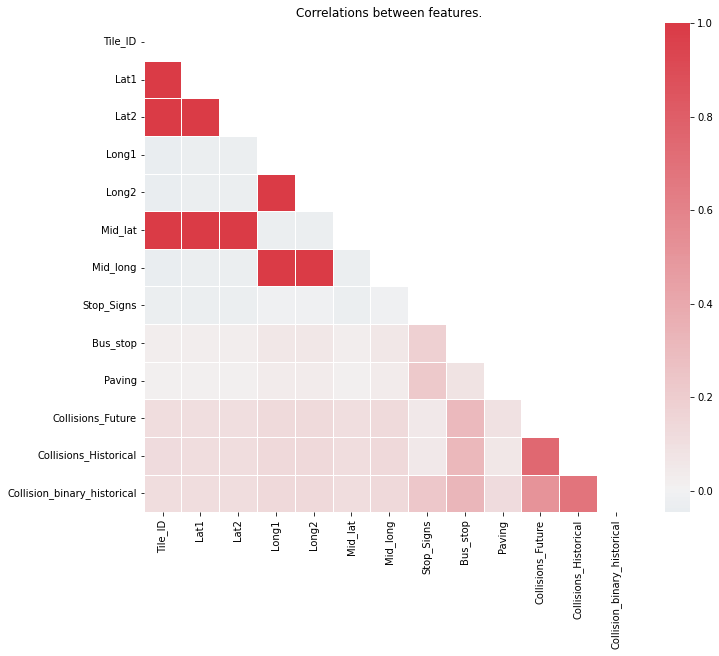

In [ ]:
corr = tiles[columns_all[:-1]].corr()
fig, ax = mp.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
mp.title("Correlations between features.")
mp.show()

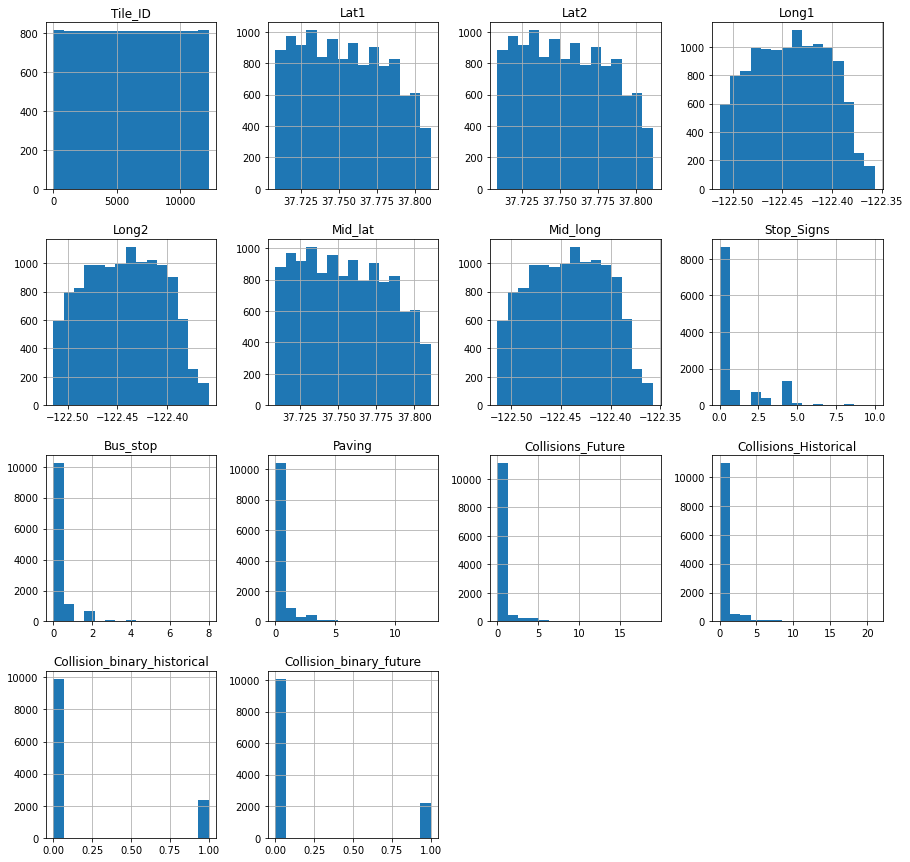

In [ ]:
tiles[columns_all[:]].hist(figsize=(15,15), bins=15)
mp.show()

In [ ]:
print('How many tiles had the same historical and future number of collisions')
x1 = len(tiles.loc[tiles['Collisions_Historical'] == tiles['Collisions_Future']])
print(x1)

print('How many had future number of collisions go up')
x2 = len(tiles.loc[tiles['Collisions_Historical'] < tiles['Collisions_Future']])
print(x2)

print('How many had future number of collisions go down')
x3 = len(tiles.loc[tiles['Collisions_Historical'] > tiles['Collisions_Future']])
print(x3)

How many tiles had the same historical and future number of collisions
9551
How many had future number of collisions go up
1202
How many had future number of collisions go down
1474


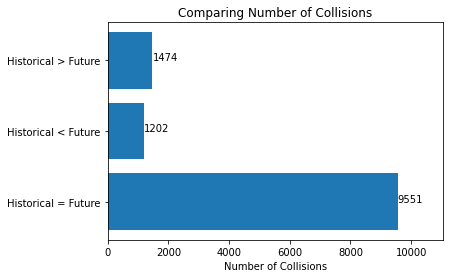

In [ ]:
data = {'Historical = Future': x1, 'Historical < Future': x2, 'Historical > Future': x3}
labels = list(data.keys())
values = list(data.values())

fig, ax = mp.subplots()
ax.barh(labels, values)

for i, value in enumerate(values):
    ax.text(value + 3, i, str(value))
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin, 1.1*xmax)

mp.title('Comparing Number of Collisions')
mp.xlabel('Number of Collisions')
mp.show()

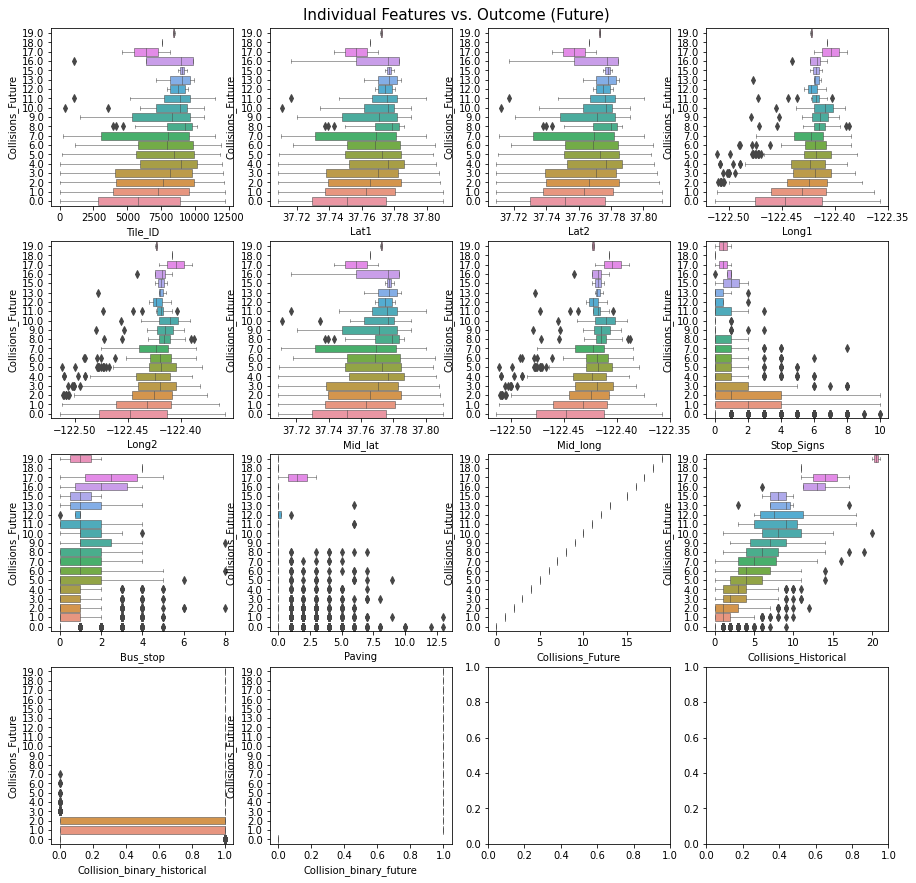

In [ ]:
fig, ax_grid = mp.subplots(4, 4, figsize=(15,15))
y = tiles['Collisions_Future']
for idx, feature in enumerate(columns_all[:]):
    x = tiles[feature]
    sns.boxplot(x=x, y=y, ax=ax_grid[idx//4][idx%4], orient='h', linewidth=.5)
    ax_grid[idx//4][idx%4].invert_yaxis()
fig.suptitle("Individual Features vs. Outcome (Future)", fontsize=15, y=0.9)
mp.show()

**Dealing with Imbalanced Dataset**

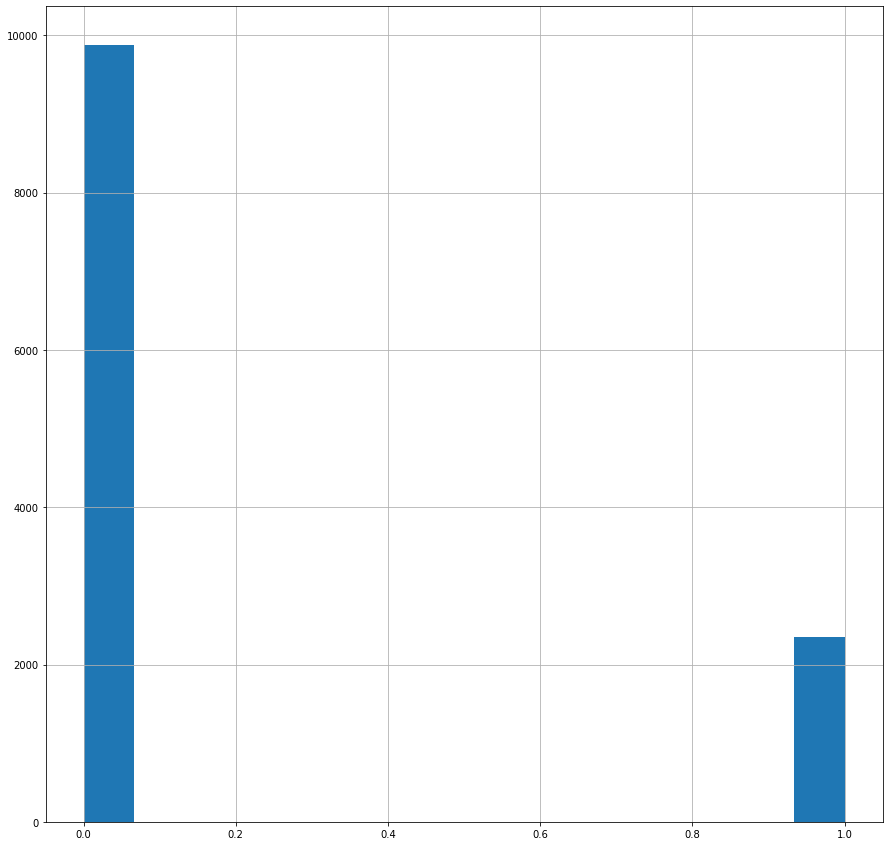

In [ ]:
tiles["Collision_binary_historical"].hist(figsize=(15,15), bins=15)
mp.show()

In [ ]:
major_count = tiles["Collision_binary_historical"].value_counts()[0]
minor_count = tiles["Collision_binary_historical"].value_counts()[1]
ratio = major_count/minor_count
print("majority class :", major_count)
print("minority class :", minor_count)
print("ratio :", ratio)

majority class : 9875
minority class : 2352
ratio : 4.198554421768708


In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = tiles.loc[tiles["Collision_binary_historical"] == 0]
df_minority = tiles.loc[tiles["Collision_binary_historical"] == 1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=int(major_count/ratio))
df_majority_downsampled = pd.concat([df_majority_downsampled, df_minority])

#Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=int(minor_count*ratio))
df_minority_upsampled = pd.concat([df_minority_upsampled, df_majority])


In [ ]:
df_majority_downsampled["Collision_binary_historical"].value_counts()

0    2352
1    2352
Name: Collision_binary_historical, dtype: int64

In [ ]:
df_minority_upsampled["Collision_binary_historical"].value_counts()

1    9875
0    9875
Name: Collision_binary_historical, dtype: int64

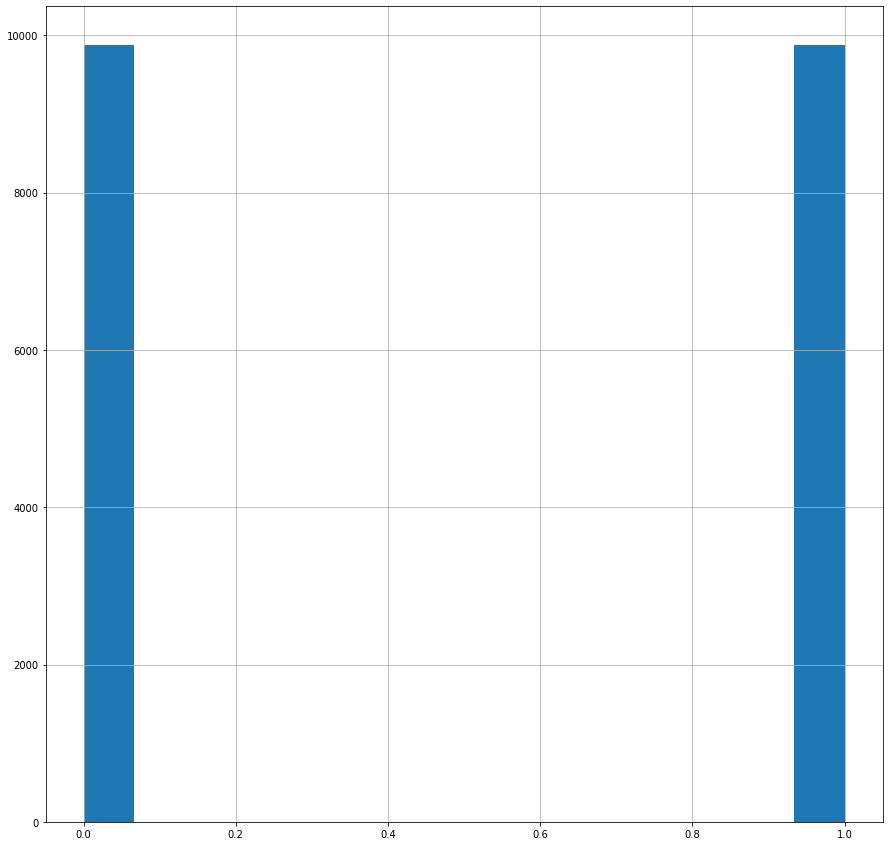

In [ ]:
#Use majority downsampled or minority upsampled datasets
#tiles = df_majority_downsampled
tiles = df_minority_upsampled
tiles["Collision_binary_historical"].hist(figsize=(15,15), bins=15)
mp.show()

Exporting final joined and balanced tiles data to csv

In [ ]:
tiles.to_csv('Tiles_expanded_balanced.csv') 
files.download('Tiles_expanded_balanced.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>